# Design of a disturbance observer for discrete-time linear systems

Simulation code of the paper presented by Dongyeop Kang at the 14th International Conference on Control, Automation and Systems. A convex optimization approach is proposed to address observer design problem for discrete-time linear systems with unknown input/output disturbances. For details, see [http://dx.doi.org/10.1109/ICCAS.2014.6987772](http://dx.doi.org/10.1109/ICCAS.2014.6987772).

## Problem formulation

Consider the following discrete-time linear dynamical system

$$
\begin{align}
\begin{cases}
x (k+1) = A x(k) + B u(k) + E d(k) \\
y (k) = C x(k) + D u(k) + F d(k)
\end{cases}
\end{align}
$$

where $x(k)$ is the state vector,  $u(k)$ is the control input, $y(k)$ is the measured output and $d(k)$ is the unknown disturbance. $A$, $B$, $C$, $D$, $E$ and $F$ are constant matrices with appropriate dimensions.

The goal is used to estimate state and disturbance of the system by the following observer:

\begin{align}
\begin{cases}
\hat{x}(k+1) = A\hat{x}(k) + B u(k) + L(y(k)-\hat{y}(k)) + E \hat{d}(k) \\
\hat{d}(k+1) = \hat{d}(k) + K(y(k)-\hat{y}(k)) \\
\hat{y}(k) = C\hat{x}(k) + D u(k) + F \hat{d}(k)
\end{cases}
\end{align}

where $\hat{x}(k)$ is the state estimate, $\hat{y}(k)$ is the output estimate, $\hat{d}(k)$ is the disturbance estimate,
$L$ and $F$ are the observer gain matrices.

Define state estimation error $\epsilon (k) = x(k) - \hat{x}(k)$ 
and disturbance estimation error $\varepsilon (k) = d(k) - \hat{d}(k)$. 
Then, we can obtain error dynamics as

\begin{align}
\epsilon(k+1) &= (A-LC)\epsilon(k)+(E-LF)\varepsilon(k), \\
\varepsilon(k+1) &=  d(k+1) - \hat{d}(k+1) \\
&= \varepsilon(k) - (\hat{d}(k+1)-\hat{d}(k)) + (d(k+1)-d(k)) \nonumber \\
&= \varepsilon(k) - K(C\epsilon(k) + F\varepsilon(k)) + \Delta d(k) \nonumber
\end{align}

where $\Delta d(k) = d(k+1) - d(k)$.

The augmented system is expressed as

\begin{align}
\begin{cases}
e(k+1) = \left[\begin{array}{cc} A-LC & E-LF \\ -KC & I-KF \end{array}\right] e(k) + \left[\begin{array}{c} 0 \\ \Delta d(k) \end{array}\right] = \Lambda e(k) + \tilde{B}\Delta d(k), \nonumber \\
z(k) = He(k) \nonumber
\end{cases}
\end{align}

where

\begin{align}
e(k) &= \left[\begin{array}{c} \epsilon(k) \\ \varepsilon(k) \end{array}\right], \quad
\tilde{A} = \left[\begin{array}{cc} A & E \\ 0 & I \end{array}\right], \quad
\tilde{B} = \left[\begin{array}{c} 0 \\ I \end{array}\right], \nonumber \\
\tilde{C} &= \left[\begin{array}{cc} C & F  \end{array}\right], \quad
G = \left[\begin{array}{c} L \\ K \end{array}\right], \nonumber
\end{align}

$\Lambda = \tilde{A} - G\tilde{C}$ and $z(k)$ is the estimated output.

## Proposed design method

If there exist matrices $P=P^T>0$, $X$, $\tilde{G}$ and a scalar $\gamma > 0$
such that following conditions hold,

\begin{align}
\left[\begin{array}{cccc}
P-X-X^T & Y & 0 & X^T\tilde{B} \\
Y^T & -P & H^T & 0 \\
0 & H & -I & 0 \\
\tilde{B}^T X & 0 & 0 & -\gamma^2 I
\end{array}\right] < 0
\end{align}

where $Y=X^T\tilde{A}-\tilde{G}\tilde{C}$,
then the stabilization of the augmented system and the $H_{\infty}$ criterion 
$J = \sum_{k=0}^{\infty} \lbrace \lVert z_{k} \rVert^2 - \gamma^2 \lVert \Delta d_{k} \rVert^2 \rbrace < 0$
is fulfilled with a minimum attenuation level $\gamma$.
The observer gains are given as $G = (X^T)^{-1}\tilde{G}$.

### Helper functions

In [1]:
%matplotlib inline
from matplotlib.pyplot import figure, plot, show, title, legend, grid
from numpy import array, mat, bmat, zeros, eye, sqrt, sin, cos
from numpy.linalg import inv
from cvxpy import Variable, Problem, Minimize
import cvxpy as cvx

def O(num_rows, num_cols):
    '''
    Return a new array of given shape filled with zeros
    '''
    return mat(zeros((num_rows,num_cols)))

def triu2sym(M, dim):
    '''
    Convert the upper triangular matrix of CVXPY variables into the symmetric matrix
    '''
    seq = range(1, dim+1)
    rows = []
    for r in seq:
        cols = []
        for c in seq:
            if r > c:
                cols.append('M[%d,%d].T' % (c, r))
            else:
                cols.append('M[%d,%d]' % (r, c))
        rows.append('[%s]' % ','.join(cols))
    return cvx.bmat(eval('[%s]' % ','.join(rows)))

def sig_disturb(k):
    '''
    Generate the disturbance signals
    '''
    return mat([[sin(0.2*k)+3*cos(0.05*k), cos(0.1*k)+2*sin(0.06*k)]]).T

### Problem data

In [2]:
# System matrices
A = mat([[0,0,0,-0.1],[0.1,-0.1,0,-0.6],[0,0.3,0.9,0.6],[0,0.2,0.6,-0.9]])
B = E = mat([[-0.3,0],[-0.3,0.8],[0,0],[0.3,0]])
C = mat([[1,0,0,-0.1],[0.8,-0.9,0.4,-0.3]])
D = F = mat([[0.1,0],[0,0.1]])
H = bmat([[C,F]])

nx, ny, nz, nd = A.shape[0], C.shape[0], H.shape[0], E.shape[1]

# Augmented system
Ao = bmat([[A,E],[zeros((nd,nx)),eye(nd)]])
Bo = bmat([[zeros((nx,nd))],[eye(nd)]])
Co = bmat([[C,F]])

# CVXPY variables
P = Variable(nx+nd,nx+nd)
X = Variable(nx+nd,nx+nd)
G = Variable(nx+nd,ny)
gamma2 = Variable(1,1)

### Solving the linear matrix inequality (LMI)

In [3]:
M = {}
M[1,1] = P-X-X.T
M[1,2] = X.T*Ao-G*Co
M[1,3] = zeros((nx+nd,nz))
M[1,4] = X.T*Bo
M[2,2] = -P
M[2,3] = H.T
M[2,4] = zeros((nx+nd,nd))
M[3,3] = -eye(nz)
M[3,4] = zeros((nz,nd))
M[4,4] = -gamma2*eye(nd)
M = triu2sym(M,4)

cons = [P >> 0, P == P.T, M << 0, gamma2 > 0]
objs = Minimize(gamma2)
prob = Problem(objs, cons)
prob.solve(kktsolver='robust')

G = inv(X.value.T)*G.value
print 'Observer gain matrix:'
print G

print 'Minimum value of gamma:'
print sqrt(gamma2.value)

Observer gain matrix:
[[ 0.87342173  0.14194314]
 [ 0.41183844  0.42134885]
 [-3.17397515  3.23628816]
 [-0.73894569  0.98045321]
 [-2.39426256 -0.72045041]
 [-1.69407369  0.81945693]]
Minimum value of gamma:
0.922415065404


### Simulation

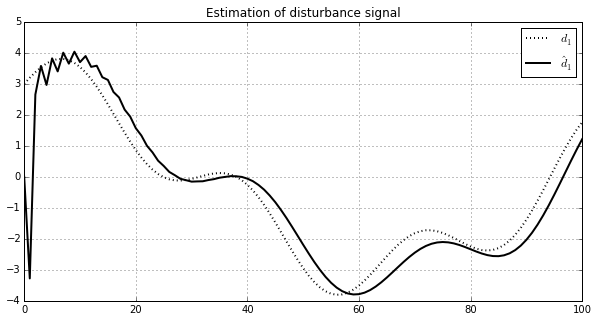

In [4]:
L = G[0:nx,:] # Feedback gain of state observer
K = G[nx:nx+nd,:] # Feedbck gain of disturbance observer

N = 100 # Number of timesteps

x, x_est, d, d_est = O(nx,N+1), O(nx,N+1), O(nd,N+1), O(nd,N+1)
x[:,0] = mat([[1,0.1,0.5,-0.5]]).T # Initial conditions

for k in range(0, N):
    y_err = C*(x[:,k] - x_est[:,k])
    d[:,k] = sig_disturb(k)
    x[:,k+1] = A*x[:,k] + E*d[:,k]
    x_est[:,k+1] = A*x_est[:,k] + L*y_err + E*d_est[:,k]
    d_est[:,k+1] = d_est[:,k] + K*y_err
d[:,k+1] = sig_disturb(k+1)

# Plot the simulation results
figure(figsize=(10,5))
plot(array(d[0,:].T), label='$d_1$', linestyle='dotted', linewidth=2, color='#000000')
plot(array(d_est[0,:].T), label='$\hat{d}_1$', linestyle='solid', linewidth=2, color='#000000')
title('Estimation of disturbance signal')
legend(loc='upper right', numpoints=1)
grid(True)
show()